# Partie 2 - Machine Learning
Entrainement d'un modèle XGBoost  dans <a href="http://datascience.ibm.com">IBM Watson Studio</a> et publication du modèle entrainé dans <a href="https://www.ibm.com/cloud/machine-learning">Watson ML</a>

Cet exemple est basé sur le challenge Kaggle AdTracking Fraud detection disponible <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">ici</a>
<br> Il s'agit de prédire la probabilité de conversion (colonne is_attributed) à partir d'un historique de clicks web (adresse IP, device, os, canal, type d'app, timestamp...)

Voir également: 
<ul>
    <li> <a href="https://github.com/obarrot/dsx/blob/master/AdTracking%20Data%20Exploration.ipynb">Partie 1</a> - Notebook d'exploration des données
    <li> Partie 3 - Client web Py Flask qui exploite le modèle déployé
    <li> Autres exemples sur <a href="https://github.com/obarrot/dsx">GitHub</a>
</ul>
<img src="http://biblioteca.uoc.edu/sites/default/files/IBM_Data%20Science.png">

# 1. Initialisation et lecture des données
### 1.1 Installation et import des libraries
On insère automatiquement les données d'authentification et les refs vers les fichiers du Cloud Object Storage via click sur Files > "insert to code"

In [1]:
!pip install graphviz

In [2]:
#!pip install xgboost --upgrade
!pip install xgboost==0.6a2

Requirement not upgraded as not directly required: xgboost==0.6a2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from xgboost==0.6a2)
Requirement not upgraded as not directly required: scikit-learn in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from xgboost==0.6a2)
Requirement not upgraded as not directly required: scipy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from xgboost==0.6a2)


In [3]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# The code was removed by DSX for sharing.

### 1.2. Lecture et formatage du fichier
Fichier d'entrainement  = train_sample.csv, 100000 lignes

In [5]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [6]:
# Upload your train_sample.csv file and use Watson Studio's import to code feature to read it for there 
    
train = pd.read_csv(body, usecols=train_columns, dtype=dtypes)
#train.info()

# 2. 1ère analyse des données brutes

In [7]:
train.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [8]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


# 3. Feature engineering

### 3.1 Feature selection

On splitte le jeu d'entrainement en input+output

In [9]:
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)
#test.drop(['click_id'], axis=1, inplace=True)

In [10]:
sub = pd.DataFrame()
gc.collect()

22

In [11]:
train.head()
#test.head()

,ip,app,device,os,channel,click_time
0,87540,12,1,13,497,2017-11-07 09:30:38
1,105560,25,1,17,259,2017-11-07 13:40:27
2,101424,12,1,19,212,2017-11-07 18:05:24
3,94584,13,1,13,477,2017-11-07 04:58:08
4,68413,12,1,1,178,2017-11-09 09:00:09


In [12]:
nrow_train = train.shape[0]
print (nrow_train)

#merge = pd.concat([train, test])
#del train, test

merge = train
gc.collect()

100000


0

### 3.2 Creation de nouvelles colonnes et suppression des colonnes d'origine correspondantes
On transforme certaines colonnes puis on suppprime les colonnes inutiles:

On compte le # de clicks par ip: aggrégation ip > clickByIp puis suppression de la colonne

In [13]:
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
ip_count.head()

,ip,clicks_by_ip
0,9,1
1,10,3
2,19,1
3,20,4
4,25,1


In [14]:
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)
#merge.describe()

In [15]:
train = merge[:nrow_train]
test = merge[nrow_train:]
del test, merge
gc.collect()
#train.head()

65

Transformation de la colonne click_time (timestamp) en jours de l'année/heure du jour exploitable par le modèle

In [16]:
def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    #df['dow']      = df['datetime'].dt.dayofweek
    df['doy']      = df['datetime'].dt.dayofyear
    df['hod']      = df['datetime'].dt.hour
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day    
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [17]:
train = timeFeatures(train)
gc.collect()

21

In [18]:
train[:10]

,app,device,os,channel,clicks_by_ip,doy,hod
0,12,1,13,497,8,311,9
1,25,1,17,259,149,311,13
2,12,1,19,212,2,311,18
3,13,1,13,477,3,311,4
4,12,1,1,178,4,313,9
5,3,1,17,115,2,313,1
6,1,1,17,135,8,313,1
7,9,1,25,442,5,311,10
8,2,2,22,364,5,312,9
9,3,1,19,135,1,312,12


##  4. Entrainement du modèle

Now that we have our feature engineered data, we have a vast array of algorythms available to create our model (scikit-learn, xgboost, sparkML, tensorflow, H2O ...). It is a common thing to train several of these models and compare (or even combine) them in order to have the best possible solution.

Here we chose to just train an XGBoost model, which is a very fast and efficient way to compute "decision trees" (gradient boosted trees).

More info on what XGBoost is and why to use it there : https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/


### 4.1 Parameter tuning 

In [19]:
params = {'eval_metric': 'auc', 
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'silent': True}

These are the parameters of our model. they have been found using grid-search techniques, which usually implies to run the training for every possible combinations of parameters that seem relevant to the data scientist, based on intuition and experimentations.

It is very time consuming and intense computing-wise, so for the sake of this example, we will just assume that these are the optimal paremeters.

### 4.2 Entrainement sur les données train_sample
On mesure l'AUC (Area Under Curve). L'optimum est obtenu après 35 itérations, après quoi le modèle se dégrade (overfitting)

In [20]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
del x1, y1, x2, y2 
gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
#nbrounds = 25
nbrounds = 25
xgb_eval = {}
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, evals_result=xgb_eval, early_stopping_rounds = nbrounds, verbose_eval=5)
del dvalid
del dtrain
del train
gc.collect()

[0]	train-auc:0.5	valid-auc:0.5
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.86201	valid-auc:0.866734
[10]	train-auc:0.862221	valid-auc:0.866801
[15]	train-auc:0.947177	valid-auc:0.966731
[20]	train-auc:0.96716	valid-auc:0.972939
[25]	train-auc:0.972379	valid-auc:0.979031
[30]	train-auc:0.972349	valid-auc:0.976489
[35]	train-auc:0.976247	valid-auc:0.98242
[40]	train-auc:0.977637	valid-auc:0.976924
[45]	train-auc:0.978981	valid-auc:0.977074
[50]	train-auc:0.980395	valid-auc:0.977542
[55]	train-auc:0.981602	valid-auc:0.976126
[60]	train-auc:0.981891	valid-auc:0.975813
Stopping. Best iteration:
[37]	train-auc:0.976715	valid-auc:0.982466



35

### 4.3 Evaluation du modèle
On affiche la courbe ROC 

Text(0.5,0,'Number of iterations')

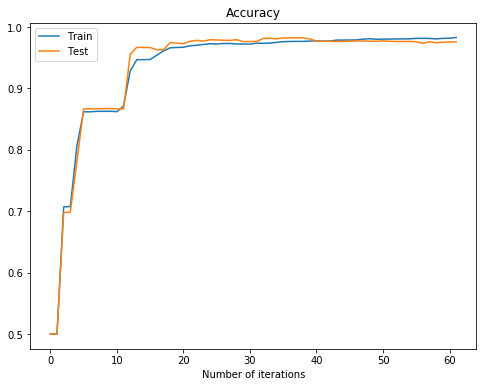

In [21]:
#xgb_eval
eval_steps = range(len(xgb_eval['train']['auc']))
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [x for x in xgb_eval['train']['auc']], label='Train')
ax.plot(eval_steps, [x for x in xgb_eval['valid']['auc']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

On affiche l'importance des features sur la prédiction et l'arbre obtenu

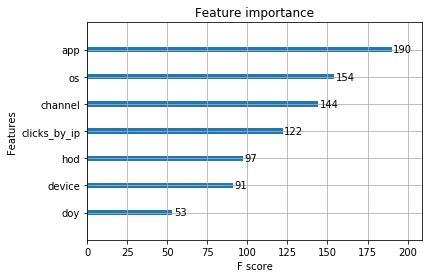

In [22]:
plot_importance(model)
plt.show()

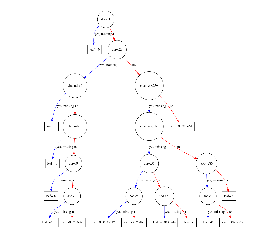

In [23]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot') 
#plt.figure(figsize=(40,40))
xgb.plot_tree(model, num_trees=2) 
ax = xgb.to_graphviz(model, num_trees=2)
plt.show()

## 5. Utilisation du modèle pour faire des prédictions

Maintenant que nous avons un bon modèle entrainé nous allons l'utiliser pour prédire sur le jeu de test !

### 5.1 Lecture du jeu de test
test.csv, 18M de lignes. <br>Sur notre sandbox d'évaluation j'ai limité le # de lignes lues à 100000

In [24]:
# The code was removed by DSX for sharing.

In [25]:
# Upload your test.csv file and use Watson Studio's import to code feature to read it for there 
# changer le # de lignes à lire + bas    
test = pd.read_csv(body, usecols=test_columns, dtype=dtypes, nrows=100000)

#test.head()

### 5.2 Feature engineering sur le jeu de test

In [26]:
ip_count = test.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']

In [27]:
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

5369

In [28]:
test.head()

,click_id,ip,app,device,os,channel,click_time,clicks_by_ip
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2
1,1,119901,9,1,3,466,2017-11-10 04:00:00,16
2,2,72287,21,1,19,128,2017-11-10 04:00:00,15
3,3,78477,15,1,13,111,2017-11-10 04:00:00,9
4,4,123080,12,1,13,328,2017-11-10 04:00:00,5


In [29]:
test.describe()

,click_id,ip,app,device,os,channel,clicks_by_ip
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,63285.356650,11.833500,1.471380,18.411250,266.481270,20.381980
std,28867.657797,36486.043192,10.884984,22.279523,10.572121,136.471051,50.103823
min,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,24999.750000,32560.000000,3.000000,1.000000,13.000000,137.000000,5.000000
50%,49999.500000,64032.000000,12.000000,1.000000,18.000000,232.000000,9.000000
75%,74999.250000,94878.000000,15.000000,1.000000,19.000000,409.000000,16.000000
max,99999.000000,126371.000000,435.000000,2865.000000,287.000000,497.000000,437.000000


In [30]:
sub['click_id'] = test['click_id'].astype('int')
test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)

### 5.3 Appel du modèle entrainé

In [31]:
dtest = xgb.DMatrix(test)
#del test
gc.collect()

56

In [32]:
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

### 5.4. Affichage du résultat et des KPIs
On remarque un petit écart statistique entre la prédiction et la valeur attendue

In [33]:
sub.head()

,click_id,is_attributed
0,0,0.001333
1,1,0.000681
2,2,-0.000850
3,3,-0.000404
4,4,0.000435


In [34]:
sub[sub['is_attributed']>0.5]

,click_id,is_attributed
10811,10811,0.600906
15605,15603,0.505446
16096,16096,0.595736
33537,33537,0.541547
36701,36701,0.679731
40053,40053,0.661889
56258,56258,0.661889
58060,58058,0.600906
65397,65397,0.600907
69344,69344,0.661889


L'écart est plus important sur les lignes attribuées ce qui est normal vu la faible pertinence statistique
<br>Pour bien faire il faudrait amplifier ces cas avant d'entrainer le modèle

In [35]:
from sklearn.metrics import precision_recall_fscore_support as metrics
from sklearn.metrics import confusion_matrix
ypred = sub['is_attributed']
#accuracy_score (y, ypred.round(),normalize=False)
prec, recall, f1score, support = metrics(y, ypred.round())


#print ('Accuracy:', accuracy_score(y, ypred))
print ('F1 score:', f1score)
print ('Precision:', prec)
print ('Recall:', recall)
#print('Support:', support)

F1 score: [ 0.99880357  0.        ]
Precision: [ 0.99772973  0.        ]
Recall: [ 0.99987973  0.        ]


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'%'), Text(0.5,0,'Features'), Text(0.5,1,'KPIs')]

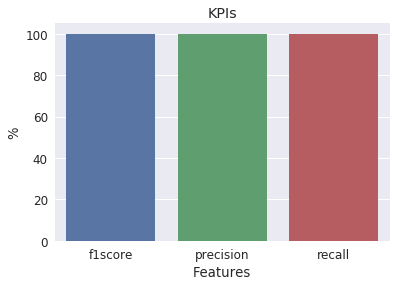

In [36]:
import seaborn as sns
import matplotlib.ticker as mtick
cols = ['f1score', 'precision', 'recall' ]
kpi = [ f1score[0]*100,prec[0]*100, recall[0]*100 ]
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.barplot(cols, kpi, log=False)
ax.set(xlabel='Features', ylabel='%', title='KPIs')


On obtient un F1 Score de 99% au global

In [37]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Affichage de la confusion matrix

Confusion matrix, without normalization
[[99761    12]
 [  227     0]]


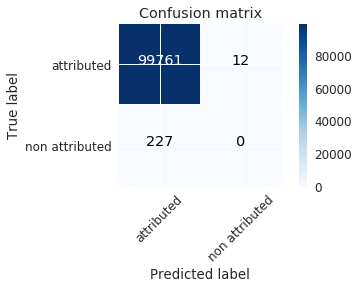

In [38]:
m = confusion_matrix(y, ypred.round())
class_names={'non attributed','attributed'}
np.set_printoptions(precision=2)
# plot confusion matrix
plt.figure()
plot_confusion_matrix(m, classes=class_names, title='Confusion matrix')
plt.show()

# 6. Déploiement et test du modèle entrainé
### 6.1 Déploiement
Nous allons maintenant déployer notre modèle entrainé sur WatsonML afin de pouvoir l'appeler via API REST 

In [39]:
test.describe()

,app,device,os,channel,clicks_by_ip,doy,hod
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0
mean,11.833500,1.471380,18.411250,266.481270,20.381980,314.0,4.0
std,10.884984,22.279523,10.572121,136.471051,50.103823,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,314.0,4.0
25%,3.000000,1.000000,13.000000,137.000000,5.000000,314.0,4.0
50%,12.000000,1.000000,18.000000,232.000000,9.000000,314.0,4.0
75%,15.000000,1.000000,19.000000,409.000000,16.000000,314.0,4.0
max,435.000000,2865.000000,287.000000,497.000000,437.000000,314.0,4.0


In [40]:
# The code was removed by DSX for sharing.

In [41]:
#headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
#url = '{}/v3/identity/token'.format(service_path)
#response = requests.get(url, headers=headers)

In [42]:
!pip install watson-machine-learning-client --upgrade
from watson_machine_learning_client import WatsonMachineLearningAPIClient

    100% |████████████████████████████████| 624kB 1.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-lear

In [43]:
# The code was removed by DSX for sharing.

In [ ]:
client = WatsonMachineLearningAPIClient(wml_credentials)
model_props = {client.repository.ModelMetaNames.NAME: "XGBoost model for AdTracking"}
model_details = client.repository.store_model(model, model_props)
client.repository.ModelMetaNames.show() 

In [ ]:
model_uid = client.repository.get_model_uid(model_details)
deployment_details = client.deployments.create(model_uid, "AdTracking prediction")
client.deployments.list()

### 6.2 Test d'appel du service REST

In [ ]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
input = test.iloc(0)[0]
#payload_scoring = {"values": input.iloc(0)[0].tolist() }
payload_scoring = {"values": [ input.tolist()] }
print(payload_scoring)

In [ ]:
# Perform prediction and display the result.
response_scoring = client.deployments.score(scoring_url, payload_scoring)
print(response_scoring)